# Project Part II - Exploration of a Modern Recommender System

# 0. Introduction

Continuing from Part I, I will be leveraging more features and will be exploring a modern recommender system with an emphasis on factorization machine.

#### The Dataset
The dataset I am analyzing is from the [KKBox Music Recommendation Challenge Kaggle Competition](https://www.kaggle.com/c/kkbox-music-recommendation-challenge). For part 1, I was focusing my analysis on three variables in train.csv: user id, song id, and target, where:
- target=1: there are recurring listening event(s) triggered within a month after the user’s very first observable listening event. In the interpretation of this practice, it indicates a "like".
- target=0: otherwise
<br><br/>
Continuing in part II, I am adding the following potential features into the analysis:
<br><br/>
User-Item Interaction:
- source_type
- source_system_tab
- source_screen_name
<br><br/>
Song Information:
* song_length
* genre_ids
* artist_name
* language
<br><br/>
User Information
* city
* registered_via: registration method
<br><br/>
Further analysis on this will be included in the data exploration & factorization machine in-depth sections.

### Objectives

Similarly to Part I, I would like to construct a model to predict the likelihood that a user will listen to a song again after hearing it for the first time. (See Part I Final Report for the business interpretation.)

My objectives are:
- Solve cold start problems that arise from sparse data
- Achieve high accuracy of prediction
- Fast and scalable solutions

# 1. Data Exploration 

### 1.1 Basic Summary
Below is a basic summary of the data set:


|categories	|amount	 |
|---	|---	|:-:	|
|# of items	|359966	 | 
|# of users	|30755 	 |
|# of likes |3714656 |   
|# of rows	|7377418 | 


Low Density & Implicit data
- This summary data tells us that the density is only 0.07% and thus we will need to take sparsity into consideration when choosing the model.
- We also notice that for those user-item pairs, half were rated like and half not. This is the explicit part of the data. The implicit meaning comes from all the user-item pairs that are not rated. 

### 1.2 Extra Song & Member Features

After conducting summary plots for all features, I have the following findings:
- The gender column is highly incomplete (i.e. more than half is unknown)
- The birthday column suffers from heavy outliers (Fig 1)
- Song artist names column suffers from long tail problem. Though there are 40582 artists, I have found that the top 500 artists take up to 75% songs that were rated. (Fig 2)

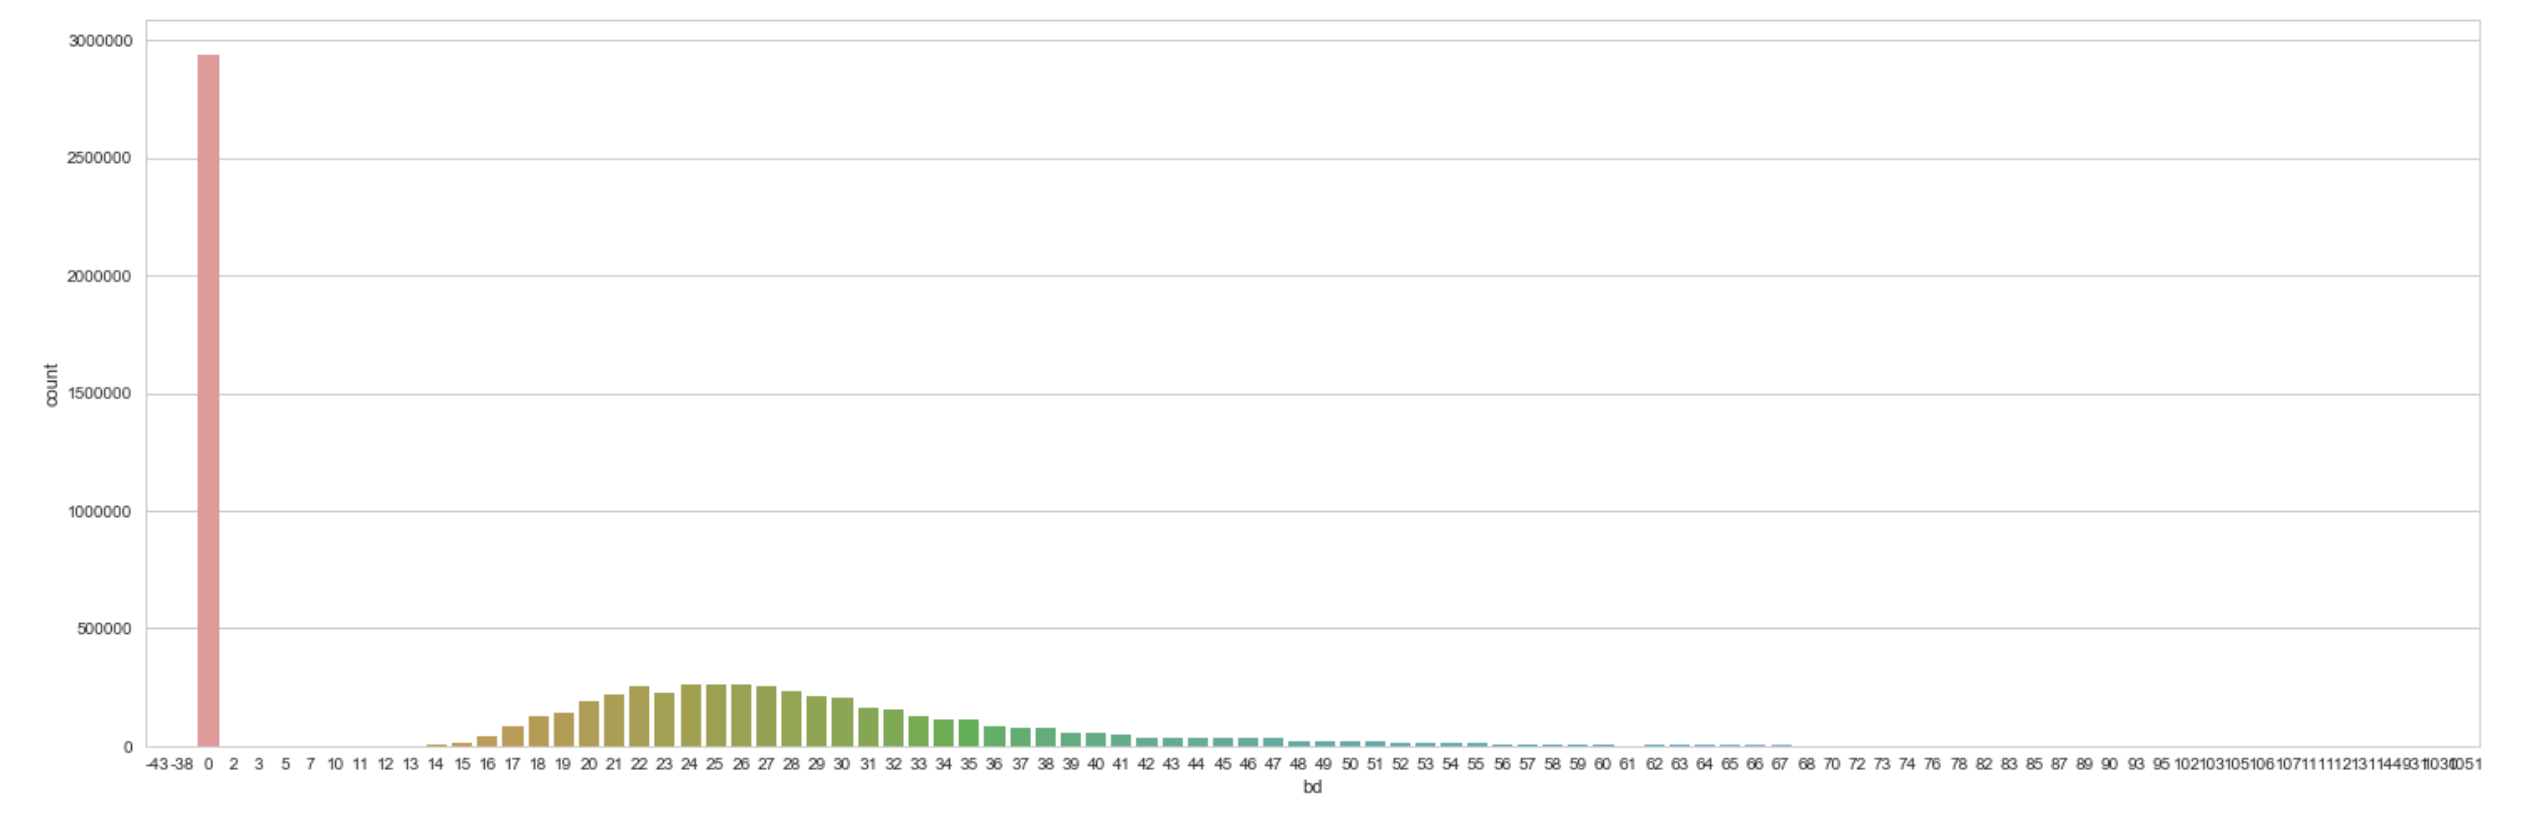

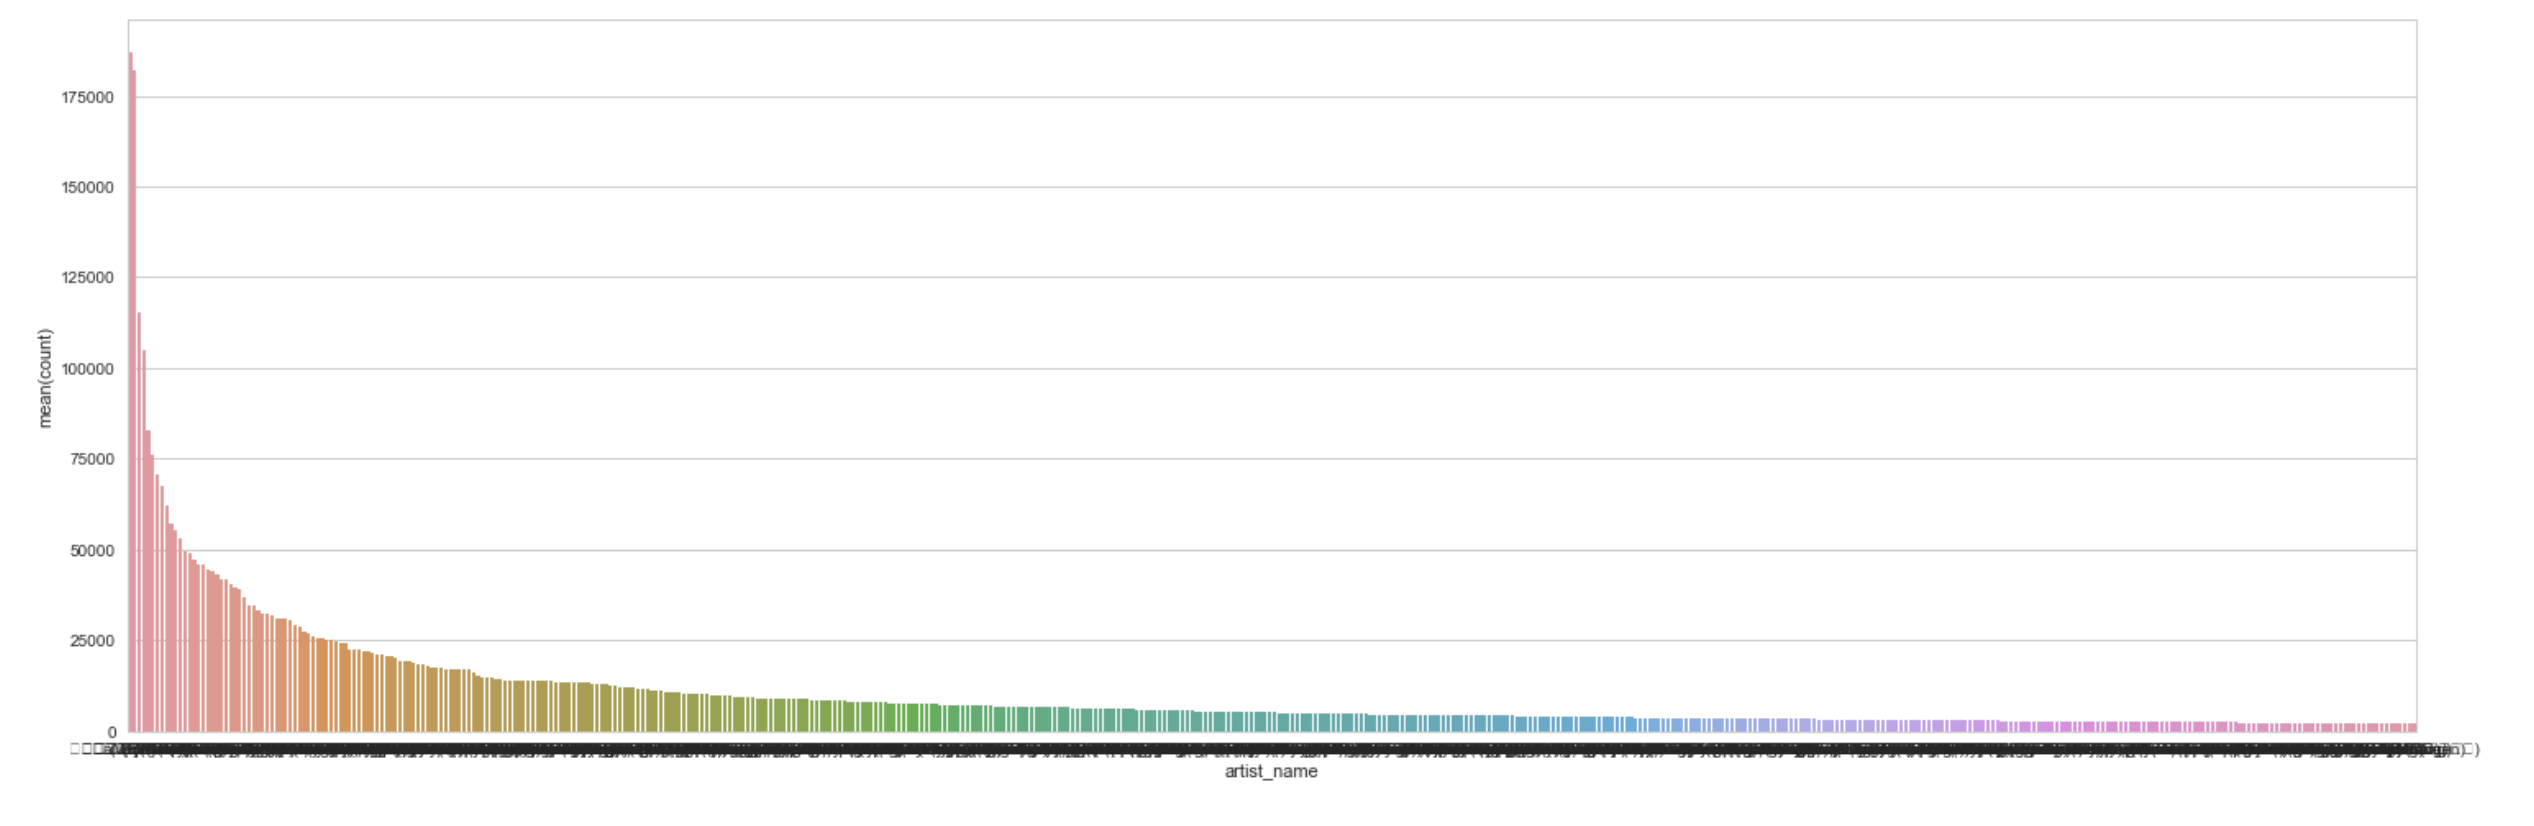

Therefore, I have decided to exclude gender and birthday columns at the moment and only include the top 500 artists and set the rest to null values.

So far, below are the data fields I wish to include in the model:
<br />
- msno
- song_id
- source_system_tab
- source_screen_name
- source_type
- song_length
- genre_ids
- artist_name
- language
- city
- registrered_via
<br />

# 2. Approaches

As the data is very sparse and has a variety of extra features, Factorization Machine would be agreat fit as it works well on sparse data and captures pair-wise feature interactions. The model equation is as follows:

$$y(x)=w_{0}+\sum_{i=1}^n w_{i}x_{i} + \sum_{i=1}^n\sum_{j=i+1}^n x_{i}x_{j}w_{ij}$$
where:
- w0 is the global bias
- wi are the weights for feature vectors xi
<Br><Br>
After transforming the data into the sparse matrix, my input for factorization machine looks something like below:


|msno1|msno2|...|song_id1|song_id2|...|local_library|search|...|Song_Length|Genre_id1|Genre_id2|...|City_1|City_2|...|Artist_1|Artist_2|...|
|---|---|:-:|---|---|---|---|---|---|---|---|---|---|---|---|
|1|0|...|0|0|1|0|0|...|213681|0|0|...|0|1|...|0|0|...|
|0|1|...|0|0|0|0|1|...|179044|0|0|...|0|0|...|0|0|...|
|0|0|...|0|0|0|0|0|...|.....|0|0|...|1|0|...|0|0|...|  
|0|0|...|1|0|1|0|0|...|.....|0|0|...|0|0|...|0|0|...|
<Br>
I will be analyzing the best combination of features in the next section.

As the data is binary, I will also add an additional logistic regression on top of the traditional FM regression as a final step. I am intested in comparing this result with the FM Classification results.

# 3. Factorization Machine in Depth

### 3.1 Baseline

As a first step, I am only feeding the user, song, and target fields into the model. This will be my baseline model. 

### 3.2 Extending the Model by Adding Side information

As a next step, I am adding each extra feature one at a time and evaluating it based on roc_auc to decide whether to include the feature or not. If the performance has gone down, I might be overfitting and thus should exclude the feature. As a result, adding the following features has increased the accuracy respectively, thus forms an optimal feature combination:
'source_screen_name', 'source_type', 'source_system_tab', 'genre_ids', 'artist_name', 'language'

### 3.3 Tuning Parameters

For FM Classification problems, there are 2 solvers I can choose from: Stochastic gradient descent and Markov chain Monte Carlo. After running them seperately, I have found that the mcmc solver performs higher than sgd and thus decided to continue with mcmc.

|  param | accuracy  |precision|recall|auc|
|---|---|:-:|---|---|
|sgd|0.582|0.557| 0.847  | 0.648656  |
| mcmc  |  0.728 |  0.738 | 0.716  |0.809248   |


The advantage of the mcmc solver is that the regularization parameters do not need to be specified, which saves the work of finding the optimal parameters. However, one drawback of mcmc is that this requires fitting and predicting at the same time, which might not be optimal for production use.

After tuning the rank parameter for mcmc, I have found that when rank=9, the highest performance is achieved:

|param|	accuracy|	precision|	recall|	auc|
|---|---|:-:|---|---|
|6|0.722	|0.732|	0.712	|0.804020|
|7	|0.725	|0.737	|0.712	|0.806057|
|8|	0.728|	0.738|	0.716|	0.809248|
|9|	0.727|	0.738|	0.714|	0.808353|
|10|	0.730|	0.740|	0.720|	0.811439 |


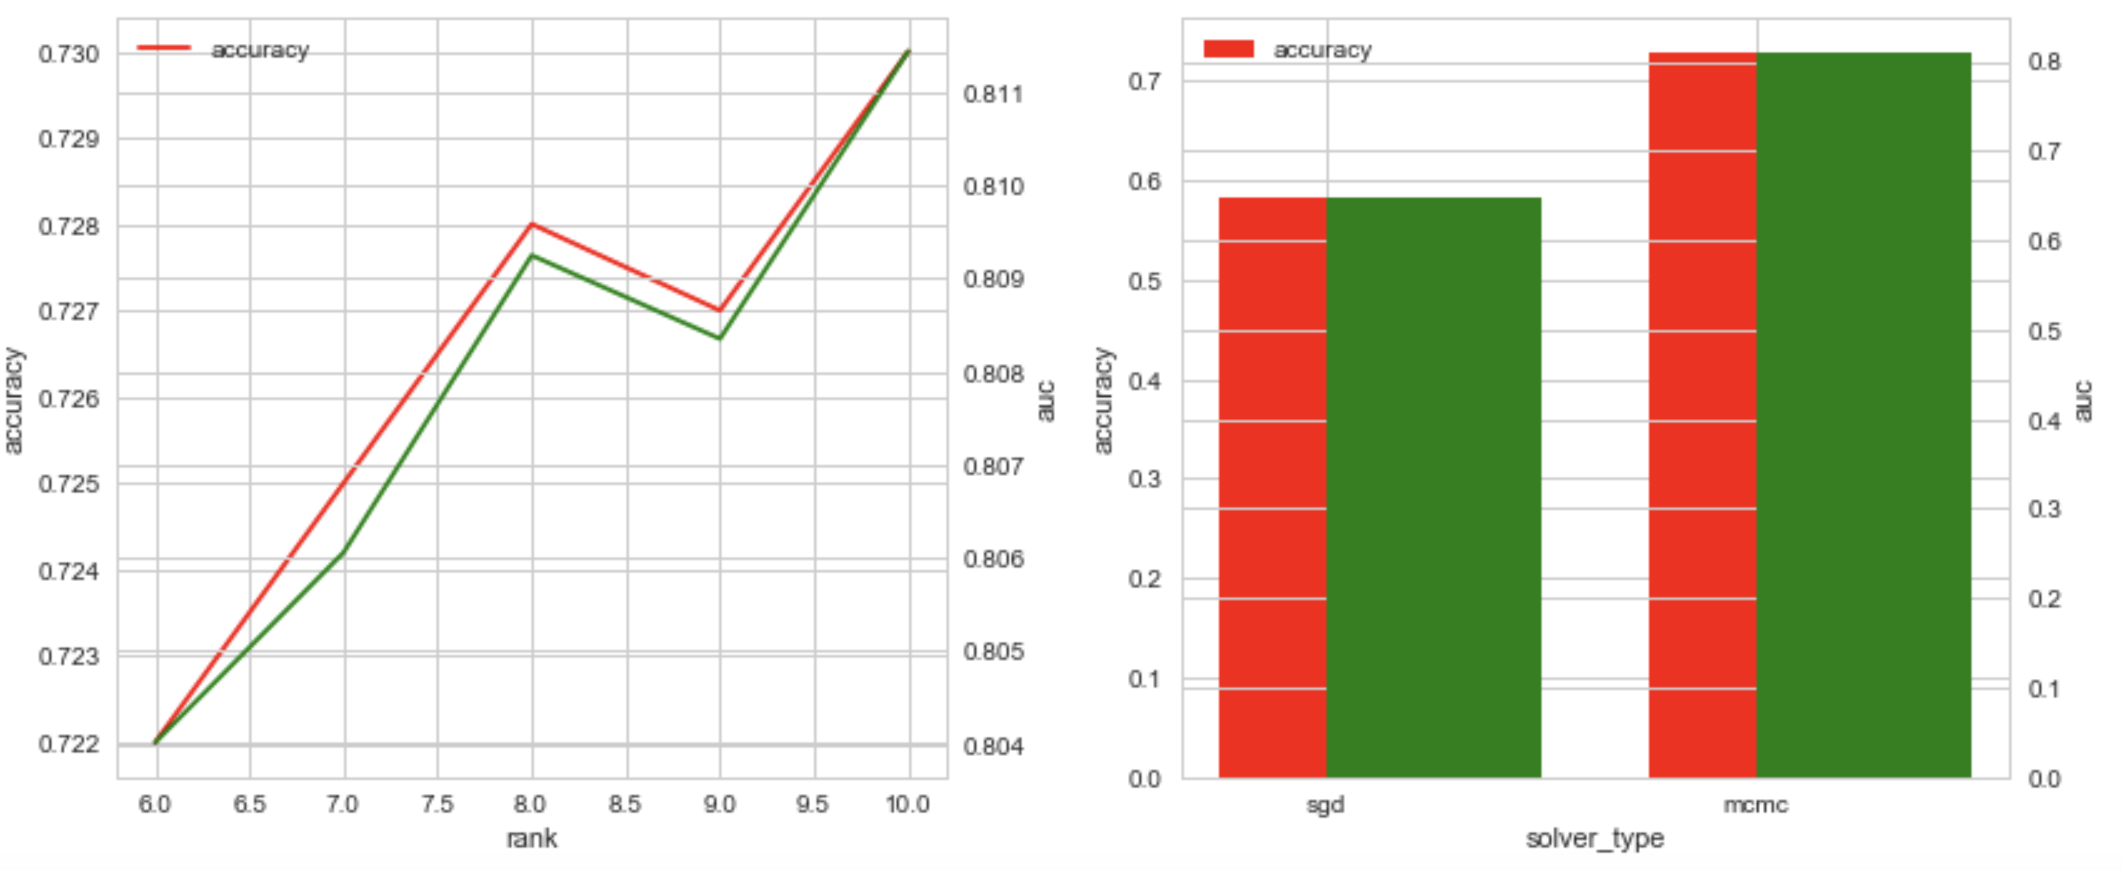

# 4. Evaluation

### 4.1 Popular Users/Items vs Normal Sampling

To futher explore the model, I would like to know if it works better on more popular items/users or normal data. To test this, I first need to segment the popular users & items by setting a threshold of 50 (i.e. a song or user is considered popular only if it has been rated by more than 50 users or the user has rated more than 50 songs, respectively). Another segment would be normal sampling from the dataset, where the density is much lower than the previous popular segment. 
After training and testing on both segments, I have achieved the following:


|  param | accuracy  |precision|recall|auc|
|---|---|:-:|---|---|
|popular|0.718|0.734|  0.738 | 0.7966639627648082 |
|normal|  0.728 |  0.738 | 0.716  |0.809248   |

Surprisingly, normal segment outperforms the popular segment by a very small amount though the popular segment has a higher recall score. This indicates a positive signal to the business: as the data from real business world always tend to be very sparse, the factorization machine model is indeed an optimal resolution to the problem.

### 4.2 Baseline Vs FM Classification Vs Hybrid (FM+LogisticRegression)

Comparing the three approaches introduced earlier in section 2, below are the results:

|  param | accuracy  |precision|recall|auc|
|---|---|:-:|---|---|
|baseline|0.666|0.674|  0.652| 0.7297111845084528 |
|FM Classification|  0.728 |  0.738 | 0.716  |0.809248   |
|FM Regression+Logistic Regression|0.736| 0.743| 0.734| 0.7364705556528766|


As shown above, both the second and third approaches outperforms the baseline where only user, item, and rating fields are treated as inputs.
The FastFM Classification approach achieves an auc score as high as 80.9% while the FM regression+logistic regression approach has only a 73.6% auc score. However, the latter one has the highest accuracy, precision, and recall scores of 0.736, 0.743, and 0.734 respectively.

From a business perspective, I would resort to the second approach since it's a one step approach compared to the third one and it has the highest auc score with insignificant decreases on the other three metrics.

# 5. Limitations & Future Consideration

### Limitations:

- Due to training heavily on historical data, when there is a new user/item added, the model needs to be trained again and is therefore less dynamic.
- The current mcmc solver does not separate training and predicting, which might be a serious problem when used in practice (training large scale data might take long time and we would not want to repeat that everytime we need to make a prediction).
- Though the model predicts the probability of whether a user would listen to a specific song with high accuracy, the model does not automatically generate a good combination of songs to recommend to users since it first requires input. In other words, one would first need to feed the song selections to the model and ask it to decide the probabilities whether the user will like the song.


### Further Explorations:

- Due to the nature of the data and the model, I have not explored evaluation metrics other than accuracy types as the model simply predicts the rating given fixed user-song pair. In the future, I might be able to conduct a hybrid model where factorization machine together with another model (e.g. CF) generating recommended lists of songs for each user. There, it’ll be more valuable for me to explore other metrics such as serendipity, coverage etc.
- As I did not include some data fields (member age, birthday, etc.) in my model at this time, I can explore feature engineering for those fields in the future (e.g. process and add in member duration time, birthday, age, etc;NLP for song lyrics etc.)

# Final Note

It has been a fun journey exploring recommender systems with professor Brett and our TA Barbara. I not only learned how they work in theory but also learned the advantages and pitfalls when using them in practice. Being in a team of 1 was very challenging yet rewarding. (Please go easy on me :p) Thank you for an awesome semester!